# 先端機械学習2022中間レポート Problem 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

In [2]:
MAX_ITERATION = 100
A = np.array([[3.0, 0.5], [0.5, 1.0]])
mu = np.array([1.0, 2.0])

In [3]:
def soft_thresholding(w, q):
  nw = np.zeros(w.shape)
  for i in range(len(w)):
    nw[i] = w[i] - q if w[i] > q else (w[i] + q if w[i] < -q else 0)
  return nw

In [4]:
def lasso(A, mu, lam):
    """
    argmin_w( (w-mu)^T A (w-mu) + lam*|w|_1 )をProximal gradientで解く
    """
    w = np.array([1,0])
    L = max(np.linalg.eig(2*A)[0])
    
    w_history = []
    w_gd_history = []
    loss_history = []
    for _ in range(MAX_ITERATION):
        d = w - mu
        loss = d.T @ A @ d + lam * np.sum(np.abs(w))
        # 記録
        w_history.append(w)
        loss_history.append(loss)
        # 更新
        grad = np.dot(2*A, d)
        w = soft_thresholding(w - 1/L * grad, lam/L)
    return w, w_history, loss_history

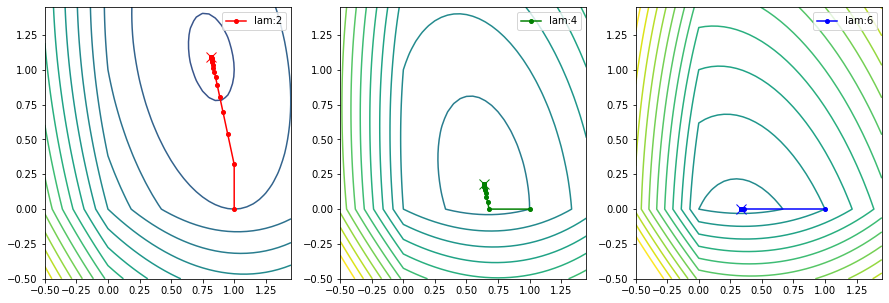

In [5]:
# 各lamに対して問題を解き、イテレーションを経るにつれてcvxで求めた解に近づく様子を確認
lams = [2,4,6]
colors = ["red", "green", "blue"]
w_history_for_lam = []
w_lasso_for_lam = []
w_for_lam = []

fig = plt.figure(figsize=(15,5))
for i in range(len(lams)):
  ax = fig.add_subplot(1, len(lams), i+1)
  lam = lams[i]
  w, w_history, loss_history = lasso(A, mu, lam)
  w_history_for_lam.append(w_history)
  w_for_lam.append(w)
  # 求めたwを順に描画
  ws = np.array(w_history)
  w1s = ws[:,0]
  w2s = ws[:,1]
  ax.plot(w1s, w2s, "o-", markersize=4, color=colors[i], label=f"lam:{lam}")
  
  # cvxでの解を求める
  w_lasso = cv.Variable((2,))
  obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
  objective = cv.Minimize(obj_fn)
  constraints = []
  prob = cv.Problem(objective, constraints)
  result = prob.solve(solver=cv.CVXOPT) 
  w_lasso = w_lasso.value
  w_lasso_for_lam.append(w_lasso)

  # cvxで求めたwをxで描画
  ax.plot(w_lasso[0], w_lasso[1], "x", markersize=10, color=colors[i])
  # lossの等高線の描画
  W1, W2 = np.meshgrid(
      np.arange(-0.5, 1.5, 0.05),
      np.arange(-0.5, 1.5, 0.05))
  w_points = np.stack([W1.flatten(), W2.flatten()], axis=1)
  ds = (w_points - mu)
  square_loss = np.ndarray(shape=(len(ds),))
  reg_loss = np.sum(np.abs(w_points),axis=1)
  for i in range(len(ds)):
      square_loss[i] = ds[i] @ A @ ds[i].T + lam * np.sum(np.abs(w_points[i]))
  ax.contour(W1, W2, square_loss.reshape(W1.shape), levels=np.arange(0, 20, 1))
  plt.legend()

In [6]:
# lamを大きくすれば第二成分が0に近づいている
w_for_lam

[array([0.81818182, 1.09090909]),
 array([0.63636364, 0.18181818]),
 array([0.33333333, 0.        ])]

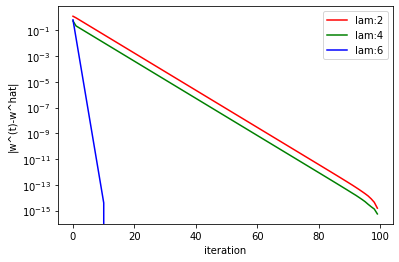

In [7]:
# |w^(t) − wˆhat|を描画
for i in range(len(lams)):
  lam = lams[i]
  w_history = w_history_for_lam[i]
  w_hat = w_for_lam[i]
  plt.plot(np.sum(np.abs(w_hat - w_history), axis=1), color=colors[i], label=f"lam:{lam}")
plt.yscale("log")
plt.ylabel("|w^(t)-w^hat|")
plt.xlabel("iteration")
plt.legend()